In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Source code

## 1.1 Sequential 

In [45]:
%%writefile sequence_ght.py
import cv2
import math
import time
import numpy as np
import matplotlib.pyplot as plt


THRESHOLD = 200
N_ROTATION_SLICES = 72
MAX_SCALE = 1.4
MIN_SCALE = 0.6
DELTA_SCALE_RATIO = 0.1
N_SCALE_SLICE = int((MAX_SCALE - MIN_SCALE) // DELTA_SCALE_RATIO + 1)
BLOCK_SIZE = 10
THRESHOLD_RATIO = 0.3
DELTA_ROTATION_ANGLE = 360 / N_ROTATION_SLICES
IMAGE_DIR = 'drive/MyDrive/images'


# numpy array sobel filter
sobel_filter_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_filter_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])


# Keep Pixel function by numpy
def keep_pixel_np(magnitude: np.ndarray, pixel_gradient: np.ndarray):
    height, width = magnitude.shape
    neighbour_one_i = np.tile(np.arange(width), (height, 1)) - (pixel_gradient == 0) + (pixel_gradient == 45) - (
            pixel_gradient == 135)
    neighbour_one_j = np.tile(np.arange(height)[:, np.newaxis], width) - (pixel_gradient == 45) - (
            pixel_gradient == 90) - (pixel_gradient == 135)
    neighbour_two_i = np.tile(np.arange(width), (height, 1)) + (pixel_gradient == 0) - (pixel_gradient == 45) + (
            pixel_gradient == 135)
    neighbour_two_j = np.tile(np.arange(height)[:, np.newaxis], width) + (pixel_gradient == 45) + (
            pixel_gradient == 90) + (pixel_gradient == 135)

    valid_neighbour_one = (neighbour_one_i >= 0) & (neighbour_one_i < width) & (neighbour_one_j >= 0) & (
            neighbour_one_j < height)
    valid_neighbour_two = (neighbour_two_i >= 0) & (neighbour_two_i < width) & (neighbour_two_j >= 0) & (
            neighbour_two_j < height)

    neighbour_one = np.zeros_like(magnitude).astype(int)
    neighbour_one[valid_neighbour_one] = magnitude[
        neighbour_one_j[valid_neighbour_one], neighbour_one_i[valid_neighbour_one]]
    neighbour_two = np.zeros_like(magnitude).astype(int)
    neighbour_two[valid_neighbour_two] = magnitude[
        neighbour_two_j[valid_neighbour_two], neighbour_two_i[valid_neighbour_two]]
    cur = magnitude

    return (neighbour_one <= cur) & (neighbour_two <= cur)


class SeqGeneralHoughTransform:
    def __init__(self, src: np.array, template: np.array, image_dir=IMAGE_DIR):
        self.src = src
        self.height_src = src.shape[0]
        self.width_src = src.shape[1]
        self.template = template
        self.height_template = template.shape[0]
        self.width_template = template.shape[1]
        self.r_table = [[] for _ in range(N_ROTATION_SLICES)]
        self.image_dir = image_dir

    def process_template(self):
        print("----------Start processing template----------\n")
        time_process = 0

        # Gray convert
        start = time.time()
        gray_template = self.convertToGray(self.template)
        end = time.time()
        print(f'\t + Time of gray scale process: {round((end - start), 5)}')
        time_process += end - start

        # Sobel filter
        start = time.time()
        magnitude_x = self.convolve(sobel_filter_x, gray_template)
        magnitude_y = self.convolve(sobel_filter_y, gray_template)
        end = time.time()
        print(f'\t + Time of sobel filter process: {round((end - start), 5)}')
        time_process += end - start

        # Magnitude and orientation
        start = time.time()
        magnitude = self.magnitude(magnitude_x, magnitude_y)
        orientation = self.orientation(magnitude_x, magnitude_y)
        end = time.time()
        print(f'\t + Time of magnitude and orientation process: {round((end - start), 5)}')
        time_process += end - start

        # Edge minmax
        start = time.time()
        edge_minmax = self.edgemns(magnitude, orientation)
        end = time.time()
        print(f'\t + Time of edge minmax process: {round((end - start), 5)}')
        time_process += end - start

        # Threshold
        start = time.time()
        mag_threshold = self.threshold(edge_minmax, THRESHOLD, type_input='template')
        end = time.time()
        print(f'\t + Time of threshold process: {round((end - start), 5)}')
        time_process += end - start

        # Create R-table
        start = time.time()
        self.create_r_table(orientation, mag_threshold)
        end = time.time()
        print(f'\t + Time of creating R-table process: {round((end - start), 5)}')
        time_process += end - start

        print("----------End processing template----------\n")
        print(f"Time processing template: {time_process}\n")

    def accumulate_src(self):
        print("----------Start accumulating src----------\n")
        time_process = 0

        # Gray convert
        start = time.time()
        gray_src = self.convertToGray(self.src)
        end = time.time()
        print(f'\t + Time of gray scale process: {round((end - start), 5)}')
        time_process += end - start

        # Sobel filter
        start = time.time()
        magnitude_x = self.convolve(sobel_filter_x, gray_src)
        magnitude_y = self.convolve(sobel_filter_y, gray_src)
        end = time.time()
        print(f'\t + Time of sobel filter process: {round((end - start), 5)}')
        time_process += end - start

        # Magnitude and orientation
        start = time.time()
        magnitude = self.magnitude(magnitude_x, magnitude_y)
        orientation = self.orientation(magnitude_x, magnitude_y)
        end = time.time()
        print(f'\t + Time of magnitude and orientation process: {round((end - start), 5)}')
        time_process += end - start

        # Edge minmax
        start = time.time()
        edge_minmax = self.edgemns(magnitude, orientation)
        end = time.time()
        print(f'\t + Time of edge minmax process: {round((end - start), 5)}')
        time_process += end - start

        # Threshold
        start = time.time()
        mag_threshold = self.threshold(edge_minmax, THRESHOLD)
        end = time.time()
        print(f'\t + Time of threshold process: {round((end - start), 5)}')
        time_process += end - start

        # Accumulate
        start = time.time()
        self.accumulate(mag_threshold, orientation)
        end = time.time()
        print(f'\t + Time of accumulate process: {round((end - start), 5)}')
        time_process += end - start

        print("----------End accumulating src----------\n")
        print(f"Time process: {time_process}s\n")

    def convertToGray(self, image, type_input=None):
        result = np.mean(image.data, axis=2)
        if type_input in ['template', 'src']:
            plt.imshow(result, cmap='gray')
            plt.savefig(f'{self.image_dir}/gray_{type_input}.png')
        return result

    def convolve(self, sobel_filter: np.array, gray_src: np.array, axis='x', type_input=None):
        if sobel_filter.shape != (3, 3):
            raise Exception("Sobel filter must be 3x3")

        result = np.convolve(gray_src.flatten(), sobel_filter.flatten(), 'same').reshape(gray_src.shape)
        if type_input in ['template', 'src']:
            plt.imshow(result, cmap='gray')
            plt.savefig(f'{self.image_dir}/sobel_{axis}_{type_input}.png')
        return result

    def magnitude(self, magnitude_x: np.array, magnitude_y: np.array, type_input=None):
        result = np.sqrt(np.square(magnitude_x) + np.square(magnitude_y))
        if type_input in ['template', 'src']:
            plt.imshow(result, cmap='gray')
            plt.savefig(f'{self.image_dir}/magnitude_{type_input}.png')
        return result

    def orientation(self, magnitude_x: np.array, magnitude_y: np.array):
        phi = np.arctan2(magnitude_y, magnitude_x)
        result = np.mod(phi * 180 / np.pi + 360, 360)
        return result

    def edgemns(self, magnitude: np.array, orientation: np.array, type_input=None):
        pixel_gradient = ((orientation // 45).astype(int) * 45 % 180)
        result = np.where(keep_pixel_np(magnitude, pixel_gradient), magnitude, 0)
        if type_input in ['template', 'src']:
            plt.imshow(result, cmap='gray')
            plt.savefig(f'{self.image_dir}/edge_minmax_{type_input}.png')
        return result

    def threshold(self, magnitude: np.array, threshold: int, type_input=None):
        result = np.where(magnitude > threshold, 255, 0)
        if type_input in ['template', 'src']:
            plt.imshow(result, cmap='gray')
            plt.savefig(f'{self.image_dir}/threshold_{type_input}.png')
            plt.plot()
        return result

    def create_r_table(self, orientation: np.array, magnitude_threshold: np.array):
        indices_j, indices_i = np.where(magnitude_threshold == 255)

        phi = np.fmod(orientation[indices_j, indices_i], 360)
        i_slice = (phi / DELTA_ROTATION_ANGLE).astype(int)

        center_x = self.width_template // 2
        center_y = self.height_template // 2
        entry_x = center_x - indices_i
        entry_y = center_y - indices_j

        r = np.sqrt(entry_x ** 2 + entry_y ** 2)
        alpha = np.arctan2(entry_y, entry_x)

        for i in range(len(indices_i)):
            entry = {'r': r[i], 'alpha': alpha[i]}
            self.r_table[i_slice[i]].append(entry)

    def accumulate(self, mag_threshold: np.array, orient: np.array):
        width = self.width_src
        height = self.height_src
        wblock = (width + BLOCK_SIZE - 1) // BLOCK_SIZE
        hblock = (height + BLOCK_SIZE - 1) // BLOCK_SIZE

        accumulator = np.zeros((hblock, wblock), dtype=np.int32)
        block_maxima = np.zeros((hblock, wblock), dtype=[('x', int), ('y', int), ('hits', int)])

        _max = 0
        for j in range(height):
            for i in range(width):
                if mag_threshold[j][i] == 255:
                    phi = orient[j][i]
                    i_slice = int(phi // DELTA_ROTATION_ANGLE)
                    entries = self.r_table[i_slice]
                    for entry in entries:
                        r = entry['r']
                        alpha = entry['alpha']
                        xc = int(i + r * math.cos(alpha))
                        yc = int(j + r * math.sin(alpha))

                        if xc < 0 or xc >= width or yc < 0 or yc >= height:
                            continue
                        accumulator[yc // BLOCK_SIZE][xc // BLOCK_SIZE] += 1
                        block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['hits'] = accumulator[yc // BLOCK_SIZE][
                            xc // BLOCK_SIZE]
                        block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['x'] = xc
                        block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['y'] = yc
                        if accumulator[yc // BLOCK_SIZE][xc // BLOCK_SIZE] > _max:
                            _max = accumulator[yc // BLOCK_SIZE][xc // BLOCK_SIZE]

        maxima_threshold = round(_max * THRESHOLD_RATIO)
        plt.imshow(self.src)
        for j in range(hblock):
            for i in range(wblock):
                if block_maxima[j][i]['hits'] > maxima_threshold:
                    plt.plot([block_maxima[j][i]['x']], [block_maxima[j][i]['y']], marker='o', color="yellow")

        plt.savefig(f'seq_output.png')
        plt.show()

if __name__ == '__main__':
    src = cv2.imread(f'{IMAGE_DIR}/leaves.png')
    template = cv2.imread(f'{IMAGE_DIR}/leaf.png')
    ght = SeqGeneralHoughTransform(src, template, image_dir=IMAGE_DIR)
    ght.process_template()
    ght.accumulate_src()

Writing sequence_ght.py


## 1.2 Sequential with numba

In [53]:
%%writefile sequence_ght_numba.py
import cv2
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import warnings
warnings.filterwarnings('ignore')

THRESHOLD = 200
N_ROTATION_SLICES = 72
MAX_SCALE = 1.4
MIN_SCALE = 0.6
DELTA_SCALE_RATIO = 0.1
N_SCALE_SLICE = int((MAX_SCALE - MIN_SCALE) // DELTA_SCALE_RATIO + 1)
BLOCK_SIZE = 10
THRESHOLD_RATIO = 0.3
DELTA_ROTATION_ANGLE = 360 / N_ROTATION_SLICES
IMAGE_DIR = 'drive/MyDrive/images'

# numpy array sobel filter
sobel_filter_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_filter_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

statictics_time = {
  'time_process_tpl': 0,
  'time_process_src': 0
}


class SeqGeneralHoughTransformNumba:
    def __init__(self, src: np.array, template: np.array, image_dir=IMAGE_DIR):
        self.src = src
        self.height_src = src.shape[0]
        self.width_src = src.shape[1]
        self.template = template
        self.height_template = template.shape[0]
        self.width_template = template.shape[1]
        self.r_table = [[] for _ in range(N_ROTATION_SLICES)]
        self.image_dir = image_dir

    def process_template(self):
        print("----------Start processing template----------\n")
        time_process = 0

        # Gray convert
        start = time.time()
        gray_template = self.convertToGray(self.template)
        end = time.time()
        print(f'\t + Time of gray scale process: {round((end - start), 5)}')
        time_process += end - start

        # Sobel filter
        start = time.time()
        magnitude_x = self.convolve(sobel_filter_x, gray_template)
        magnitude_y = self.convolve(sobel_filter_y, gray_template)
        end = time.time()
        print(f'\t + Time of sobel filter process: {round((end - start), 5)}')
        time_process += end - start

        # Magnitude and orientation
        start = time.time()
        magnitude = self.magnitude(magnitude_x, magnitude_y)
        orientation = self.orientation(magnitude_x, magnitude_y)
        end = time.time()
        print(f'\t + Time of magnitude and orientation process: {round((end - start), 5)}')
        time_process += end - start

        # Edge minmax
        start = time.time()
        edge_minmax = self.edgemns(magnitude, orientation)
        end = time.time()
        print(f'\t + Time of edge minmax process: {round((end - start), 5)}')
        time_process += end - start

        # Threshold
        start = time.time()
        mag_threshold = self.threshold(edge_minmax, THRESHOLD, type_input='template')
        end = time.time()
        print(f'\t + Time of threshold process: {round((end - start), 5)}')
        time_process += end - start

        # Create R-table
        start = time.time()
        self.create_r_table(orientation, mag_threshold)
        end = time.time()
        print(f'\t + Time of creating R-table process: {round((end - start), 5)}')
        time_process += end - start

        print("----------End processing template----------\n")
        statictics_time['time_process_tpl'] = time_process

    def accumulate_src(self):
        print("----------Start accumulating src----------\n")
        time_process = 0

        # Gray convert
        start = time.time()
        gray_src = self.convertToGray(self.src)
        end = time.time()
        print(f'\t + Time of gray scale process: {round((end - start), 5)}')
        time_process += end - start

        # Sobel filter
        start = time.time()
        magnitude_x = self.convolve(sobel_filter_x, gray_src)
        magnitude_y = self.convolve(sobel_filter_y, gray_src)
        end = time.time()
        print(f'\t + Time of sobel filter process: {round((end - start), 5)}')
        time_process += end - start

        # Magnitude and orientation
        start = time.time()
        magnitude = self.magnitude(magnitude_x, magnitude_y)
        orientation = self.orientation(magnitude_x, magnitude_y)
        end = time.time()
        print(f'\t + Time of magnitude and orientation process: {round((end - start), 5)}')
        time_process += end - start

        # Edge minmax
        start = time.time()
        edge_minmax = self.edgemns(magnitude, orientation)
        end = time.time()
        print(f'\t + Time of edge minmax process: {round((end - start), 5)}')
        time_process += end - start

        # Threshold
        start = time.time()
        mag_threshold = self.threshold(edge_minmax, THRESHOLD)
        end = time.time()
        print(f'\t + Time of threshold process: {round((end - start), 5)}')
        time_process += end - start

        # Accumulate
        start = time.time()
        block_maxima, maxima_threshold = self.accumulate(mag_threshold, orientation)
        end = time.time()
        print(f'\t + Time of accumulate process: {round((end - start), 5)}')
        time_process += end - start

        # Draw
        wblock = (self.width_src + BLOCK_SIZE - 1) // BLOCK_SIZE
        hblock = (self.height_src + BLOCK_SIZE - 1) // BLOCK_SIZE
        plt.imshow(self.src)
        for j in range(hblock):
            for i in range(wblock):
                if block_maxima[j][i]['hits'] > maxima_threshold:
                    plt.plot([block_maxima[j][i]['x']], [block_maxima[j][i]['y']], marker='o', color="yellow")

        plt.savefig(f'seq_output_numba.png')
        plt.show()

        print("----------End accumulating src----------\n")
        statictics_time['time_process_src'] = time_process

    @jit(cache=True)
    def convertToGray(self, image, type_input=None):
        result = np.zeros(image.shape[:2], dtype=np.float64)
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                result[i][j] = 0.299 * image[i][j][0] + 0.587 * image[i][j][1] + 0.114 * image[i][j][2]

        return result

    @jit(cache=True,)
    def convolve(self, sobel_filter: np.array, gray_src: np.array, axis='x', type_input=None):
        result = np.zeros_like(gray_src)
        for i in range(gray_src.shape[0]):
            for j in range(gray_src.shape[1]):
                temp = 0
                for jj in range(-1, 2):
                    for ii in range(-1, 2):
                        jj_pad = max(0, min(gray_src.shape[1] - 1, j + jj))
                        ii_pad = max(0, min(gray_src.shape[0] - 1, i + ii))
                        temp += gray_src[ii_pad][jj_pad] * sobel_filter[ii + 1][jj + 1]
                result[i][j] = temp

        return result

    @jit(cache=True)
    def magnitude(self, magnitude_x: np.array, magnitude_y: np.array, type_input=None):
        result = np.zeros_like(magnitude_x)
        for i in range(magnitude_x.shape[0]):
            for j in range(magnitude_x.shape[1]):
                result[i][j] = math.sqrt(magnitude_x[i][j] ** 2 + magnitude_y[i][j] ** 2)

        return result

    @jit(cache=True)
    def orientation(self, magnitude_x: np.array, magnitude_y: np.array):
        result = np.zeros_like(magnitude_x)
        for i in range(magnitude_x.shape[0]):
            for j in range(magnitude_x.shape[1]):
                result[i][j] = (math.atan2(magnitude_y[i][j], magnitude_x[i][j]) * 180 / math.pi + 360) % 360
        return result

    @jit(cache=True)
    def edgemns(self, magnitude: np.array, orientation: np.array, type_input=None):
        result = np.zeros_like(magnitude)
        for i in range(magnitude.shape[0]):
            for j in range(magnitude.shape[1]):
                pixel_gradient = int(orientation[i][j] // 45) * 45 % 180
                neighbour_one_i = i
                neighbour_one_j = j
                neighbour_two_i = i
                neighbour_two_j = j

                if pixel_gradient == 0:
                    neighbour_one_i = i - 1
                    neighbour_two_i = i + 1
                elif pixel_gradient == 45:
                    neighbour_one_i = i + 1
                    neighbour_one_j = j - 1
                    neighbour_two_i = i - 1
                    neighbour_two_j = j + 1
                elif pixel_gradient == 90:
                    neighbour_one_j = j - 1
                    neighbour_two_j = j + 1
                elif pixel_gradient == 135:
                    neighbour_one_i = i - 1
                    neighbour_one_j = j - 1
                    neighbour_two_i = i + 1
                    neighbour_two_j = j + 1

                neighbour_one_i = max(0, min(magnitude.shape[0] - 1, neighbour_one_i))
                neighbour_one_j = max(0, min(magnitude.shape[1] - 1, neighbour_one_j))
                neighbour_two_i = max(0, min(magnitude.shape[0] - 1, neighbour_two_i))
                neighbour_two_j = max(0, min(magnitude.shape[1] - 1, neighbour_two_j))

                neighbour_one = magnitude[neighbour_one_i][neighbour_one_j]
                neighbour_two = magnitude[neighbour_two_i][neighbour_two_j]

                if (neighbour_one <= magnitude[i][j]) & (neighbour_two <= magnitude[i][j]):
                    result[i][j] = magnitude[i][j]
                else:
                    result[i][j] = 0
        return result

    @jit(cache=True)
    def threshold(self, magnitude: np.array, threshold: int, type_input=None):
        result = np.zeros_like(magnitude)
        for i in range(magnitude.shape[0]):
            for j in range(magnitude.shape[1]):
                if magnitude[i][j] > threshold:
                    result[i][j] = 255
                else:
                    result[i][j] = 0
        return result

    @jit(cache=True)
    def create_r_table(self, orientation: np.array, magnitude_threshold: np.array):
        for i in range(orientation.shape[0]):
            for j in range(orientation.shape[1]):
                if magnitude_threshold[i][j] == 255:
                    phi = orientation[i][j] % 360
                    i_slice = int(phi // DELTA_ROTATION_ANGLE)

                    center_x = self.width_template // 2
                    center_y = self.height_template // 2
                    entry_x = center_x - j
                    entry_y = center_y - i

                    r = math.sqrt(entry_x ** 2 + entry_y ** 2)
                    alpha = math.atan2(entry_y, entry_x)

                    entry = {'r': r, 'alpha': alpha}
                    self.r_table[i_slice].append(entry)

    @jit(cache=True)
    def accumulate4D(self, mag_threshold: np.array, orient: np.array):
        width = self.width_src
        height = self.height_src
        wblock = (width + BLOCK_SIZE - 1) // BLOCK_SIZE
        hblock = (height + BLOCK_SIZE - 1) // BLOCK_SIZE

        accumulator = np.zeros((N_SCALE_SLICE, N_ROTATION_SLICES, hblock, wblock), dtype=np.int32)
        block_maxima = np.zeros((hblock, wblock), dtype=[('x', int), ('y', int), ('hits', int)])

        _max = 0
        for j in range(height):
            for i in range(width):
                if mag_threshold[j][i] == 255:
                    phi = orient[j][i]
                    for i_theta in range(N_ROTATION_SLICES):
                        theta = i_theta * DELTA_ROTATION_ANGLE
                        theta_r = math.radians(theta)
                        i_slice = int(((phi - theta + 360) % 360) // DELTA_ROTATION_ANGLE)
                        entries = self.r_table[i_slice]
                        for entry in entries:
                            r = entry['r']
                            alpha = entry['alpha']
                            for scale in range(N_SCALE_SLICE):
                                s = scale * DELTA_SCALE_RATIO + MIN_SCALE
                                xc = int(i + r * s * math.cos(alpha + theta_r))
                                yc = int(j + r * s * math.sin(alpha + theta_r))

                                if xc < 0 or xc >= width or yc < 0 or yc >= height:
                                    continue
                                accumulator[scale][i_theta][yc // BLOCK_SIZE][xc // BLOCK_SIZE] += 1
                                if accumulator[scale][i_theta][yc // BLOCK_SIZE][xc // BLOCK_SIZE] > \
                                        block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['hits']:
                                    block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['hits'] = \
                                        accumulator[scale][i_theta][yc // BLOCK_SIZE][xc // BLOCK_SIZE]
                                    block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['x'] = xc
                                    block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['y'] = yc
                                    if accumulator[scale][i_theta][yc // BLOCK_SIZE][xc // BLOCK_SIZE] > _max:
                                        _max = accumulator[scale][i_theta][yc // BLOCK_SIZE][xc // BLOCK_SIZE]

        maxima_threshold = round(_max * THRESHOLD_RATIO)

        return block_maxima, maxima_threshold

    @jit(cache=True)
    def accumulate(self, mag_threshold: np.array, orient: np.array):
        width = self.width_src
        height = self.height_src
        wblock = (width + BLOCK_SIZE - 1) // BLOCK_SIZE
        hblock = (height + BLOCK_SIZE - 1) // BLOCK_SIZE

        accumulator = np.zeros((hblock, wblock), dtype=np.int32)
        block_maxima = np.zeros((hblock, wblock), dtype=[('x', int), ('y', int), ('hits', int)])

        _max = 0
        for j in range(self.height_src):
            for i in range(self.width_src):
                if mag_threshold[j][i] == 255:
                    phi = orient[j][i]
                    i_slice = int(phi // DELTA_ROTATION_ANGLE)
                    entries = self.r_table[i_slice]
                    for entry in entries:
                        r = entry['r']
                        alpha = entry['alpha']
                        xc = int(i + r * math.cos(alpha))
                        yc = int(j + r * math.sin(alpha))

                        if xc < 0 or xc >= self.width_src or yc < 0 or yc >= self.height_src:
                            continue
                        accumulator[yc // BLOCK_SIZE][xc // BLOCK_SIZE] += 1
                        block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['hits'] = accumulator[yc // BLOCK_SIZE][
                            xc // BLOCK_SIZE]
                        block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['x'] = xc
                        block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['y'] = yc
                        if accumulator[yc // BLOCK_SIZE][xc // BLOCK_SIZE] > _max:
                            _max = accumulator[yc // BLOCK_SIZE][xc // BLOCK_SIZE]
        maxima_threshold = round(_max * THRESHOLD_RATIO)
        return block_maxima, maxima_threshold

if __name__ == '__main__':
    src = cv2.imread(f'{IMAGE_DIR}/leaves.png')
    template = cv2.imread(f'{IMAGE_DIR}/leaf.png')
    ght = SeqGeneralHoughTransformNumba(src, template, image_dir=IMAGE_DIR)
    ght.process_template()
    ght.accumulate_src()
    print(f"Time process template: {statictics_time['time_process_tpl']}s\n")
    print(f"Time process source: {statictics_time['time_process_src']}s\n")

Overwriting sequence_ght_numba.py


## 1.3 Parallel on GPU with numba

In [78]:
 %%writefile parallel_ght_gpu.py
import math
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, cuda
import warnings
warnings.filterwarnings('ignore')


THRESHOLD = 200
N_ROTATION_SLICES = 72
MAX_SCALE = 1.4
MIN_SCALE = 0.6
DELTA_SCALE_RATIO = 0.1
N_SCALE_SLICE = int((MAX_SCALE - MIN_SCALE) // DELTA_SCALE_RATIO + 1)
BLOCK_SIZE = 10
THRESHOLD_RATIO = 0.3
DELTA_ROTATION_ANGLE = 360 / N_ROTATION_SLICES
PHI_R_TABLE_INDEX = 0
R_R_TABLE_INDEX = 1
ALPHA_R_TABLE_INDEX = 2
IMAGE_DIR = 'drive/MyDrive/images'

# numpy array sobel filter
sobel_filter_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_filter_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])


@cuda.jit
def convert_to_gray(image: np.array, result: np.array):
    r, c = cuda.grid(2)
    if r < image.shape[0] and c < image.shape[1]:
        result[r][c] = 0.299 * image[r][c][0] + 0.587 * image[r][c][1] + 0.114 * image[r][c][2]


@cuda.jit
def convolve(sobel_filter: np.array, gray_src: np.array, result: np.array):
    r, c = cuda.grid(2)
    if r < gray_src.shape[0] and c < gray_src.shape[1]:
        temp = 0
        for jj in range(-1, 2):
            for ii in range(-1, 2):
                jj_pad = max(0, min(gray_src.shape[1] - 1, c + jj))
                ii_pad = max(0, min(gray_src.shape[0] - 1, r + ii))
                temp += gray_src[ii_pad][jj_pad] * sobel_filter[ii + 1][jj + 1]
        result[r][c] = temp


@cuda.jit
def magnitude(magnitude_x: np.array, magnitude_y: np.array, result: np.array):
    r, c = cuda.grid(2)
    if r < magnitude_x.shape[0] and c < magnitude_x.shape[1]:
        result[r][c] = math.sqrt(magnitude_x[r][c] ** 2 + magnitude_y[r][c] ** 2)


@cuda.jit
def orientation(magnitude_x: np.array, magnitude_y: np.array, result: np.array):
    r, c = cuda.grid(2)
    if r < magnitude_x.shape[0] and c < magnitude_x.shape[1]:
        result[r][c] = (math.atan2(magnitude_y[r][c], magnitude_x[r][c]) * 180 / math.pi + 360) % 360


@cuda.jit
def edgemns(magnitude: np.array, orientation: np.array, result: np.array):
    r, c = cuda.grid(2)
    if r < magnitude.shape[0] and c < magnitude.shape[1]:
        pixel_gradient = int(orientation[r][c] // 45) * 45 % 180
        neighbour_one_i = r
        neighbour_one_j = c
        neighbour_two_i = r
        neighbour_two_j = c

        if pixel_gradient == 0:
            neighbour_one_i = r - 1
            neighbour_two_i = r + 1
        elif pixel_gradient == 45:
            neighbour_one_i = r + 1
            neighbour_one_j = c - 1
            neighbour_two_i = r - 1
            neighbour_two_j = c + 1
        elif pixel_gradient == 90:
            neighbour_one_j = c - 1
            neighbour_two_j = c + 1
        elif pixel_gradient == 135:
            neighbour_one_i = r - 1
            neighbour_one_j = c - 1
            neighbour_two_i = r + 1
            neighbour_two_j = c + 1

        neighbour_one_i = max(0, min(magnitude.shape[0] - 1, neighbour_one_i))
        neighbour_one_j = max(0, min(magnitude.shape[1] - 1, neighbour_one_j))
        neighbour_two_i = max(0, min(magnitude.shape[0] - 1, neighbour_two_i))
        neighbour_two_j = max(0, min(magnitude.shape[1] - 1, neighbour_two_j))

        if magnitude[r][c] >= magnitude[neighbour_one_i][neighbour_one_j] and magnitude[r][c] >= magnitude[neighbour_two_i][neighbour_two_j]:
            result[r][c] = magnitude[r][c]
        else:
            result[r][c] = 0


@cuda.jit
def threshold(magnitude: np.array, threshold: int, result: np.array):
    r, c = cuda.grid(2)
    if r < magnitude.shape[0] and c < magnitude.shape[1]:
        if magnitude[r][c] > threshold:
            result[r][c] = 255
        else:
            result[r][c] = 0


@cuda.jit
def create_r_table(orientation: np.array, magnitude_threshold: np.array, width_template: int, height_template: int,
                   r_table: np.array):
    r, c = cuda.grid(2)
    if r < orientation.shape[0] and c < orientation.shape[1]:
        if magnitude_threshold[r][c] == 255:
            phi = orientation[r][c] % 360
            i_slice = int(phi // DELTA_ROTATION_ANGLE)

            center_x = width_template // 2
            center_y = height_template // 2
            entry_x = center_x - c
            entry_y = center_y - r

            _r = math.sqrt(entry_x ** 2 + entry_y ** 2)
            alpha = math.atan2(entry_y, entry_x)

            r_table[r, c, PHI_R_TABLE_INDEX] = i_slice
            r_table[r, c, R_R_TABLE_INDEX] = _r
            r_table[r, c, ALPHA_R_TABLE_INDEX] = alpha
        else:
            r_table[r, c, PHI_R_TABLE_INDEX] = -1

@cuda.jit
def num_edge_pixels_and_convert_r_table_to_1D(magnitude_threshold: np.array, _num_edge_pixels: int, r_table_1D: np.array, r_table: np.array):
    r, c = cuda.grid(2)
    if r < magnitude_threshold.shape[0] and c < magnitude_threshold.shape[1]:
        if magnitude_threshold[r][c] == 255:
            index = cuda.atomic.add(_num_edge_pixels, 0, 1)
            r_table_1D[index, PHI_R_TABLE_INDEX] = r_table[r, c, PHI_R_TABLE_INDEX]
            r_table_1D[index, R_R_TABLE_INDEX] = r_table[r, c, R_R_TABLE_INDEX]
            r_table_1D[index, ALPHA_R_TABLE_INDEX] = r_table[r, c, ALPHA_R_TABLE_INDEX]

@cuda.jit
def num_edge_pixels_and_get_pixel_index(magnitude_threshold: np.array, _num_edge_pixels: int, edge_pixels_1D: np.array):
    r, c = cuda.grid(2)
    if r < magnitude_threshold.shape[0] and c < magnitude_threshold.shape[1]:
        if magnitude_threshold[r][c] == 255:
            index = cuda.atomic.add(_num_edge_pixels, 0, 1)
            edge_pixels_1D[index, 0] = r
            edge_pixels_1D[index, 1] = c


@jit(cache=True)
def accumulate4D(mag_threshold: np.array, orient: np.array, width_src: int, height_src: int,
                 accumulator: np.array, block_maxima: np.array, r_table: list):
    _max = 0
    for j in range(height_src):
        for i in range(width_src):
            if mag_threshold[j][i] == 255:
                phi = orient[j][i]
                for i_theta in range(N_ROTATION_SLICES):
                    theta = i_theta * DELTA_ROTATION_ANGLE
                    theta_r = math.radians(theta)
                    i_slice = int(((phi - theta + 360) % 360) // DELTA_ROTATION_ANGLE)
                    entries = r_table[i_slice]
                    for entry in entries:
                        r = entry['r']
                        alpha = entry['alpha']
                        for scale in range(N_SCALE_SLICE):
                            s = scale * DELTA_SCALE_RATIO + MIN_SCALE
                            xc = int(i + r * s * math.cos(alpha + theta_r))
                            yc = int(j + r * s * math.sin(alpha + theta_r))

                            if xc < 0 or xc >= width_src or yc < 0 or yc >= height_src:
                                continue
                            accumulator[scale][i_theta][yc // BLOCK_SIZE][xc // BLOCK_SIZE] += 1
                            if accumulator[scale][i_theta][yc // BLOCK_SIZE][xc // BLOCK_SIZE] > \
                                    block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['hits']:
                                block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['hits'] = \
                                    accumulator[scale][i_theta][yc // BLOCK_SIZE][xc // BLOCK_SIZE]
                                block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['x'] = xc
                                block_maxima[yc // BLOCK_SIZE][xc // BLOCK_SIZE]['y'] = yc
                                if accumulator[scale][i_theta][yc // BLOCK_SIZE][xc // BLOCK_SIZE] > _max:
                                    _max = accumulator[scale][i_theta][yc // BLOCK_SIZE][xc // BLOCK_SIZE]
    maxima_threshold = round(_max * THRESHOLD_RATIO)

    return block_maxima, maxima_threshold


@cuda.jit
def accumulate(edge_pixels: np.array, num_edge_pixels: int, orient: np.array, width_src: int, height_src: int,
                 accumulator: np.array, r_table: list):
    index = cuda.grid(1)
    if (index >= num_edge_pixels):
        return

    row = edge_pixels[index, 0]
    col = edge_pixels[index, 1]

    phi = orient[row, col]
    i_slice = int(phi // DELTA_ROTATION_ANGLE)
    for entry in r_table:
        if int(entry[PHI_R_TABLE_INDEX]) == i_slice:
            r = entry[R_R_TABLE_INDEX]
            alpha = entry[ALPHA_R_TABLE_INDEX]
            xc = int(col + r * math.cos(alpha))
            yc = int(row + r * math.sin(alpha))

            if xc < 0 or xc >= width_src or yc < 0 or yc >= height_src:
                continue
            accumulator_index = (yc // BLOCK_SIZE, xc // BLOCK_SIZE)
            value_accum = cuda.atomic.add(accumulator, accumulator_index, 1)


src = cv2.imread(f'{IMAGE_DIR}/leaves.png')
height_src = src.shape[0]
width_src = src.shape[1]
template = cv2.imread(f'{IMAGE_DIR}/leaf.png')
height_template = template.shape[0]
width_template = template.shape[1]
r_table = np.zeros((height_template, width_template, 3), dtype=np.float64)
block_size = (32, 32)
grid_size_template = (math.ceil(height_template / block_size[0]), math.ceil(width_template / block_size[1]))
grid_size_src = (math.ceil(height_src / block_size[0]), math.ceil(width_src / block_size[1]))
wblock = (width_src + BLOCK_SIZE - 1) // BLOCK_SIZE
hblock = (height_src + BLOCK_SIZE - 1) // BLOCK_SIZE

print("----------Start processing template----------\n")
time_process = 0

# Gray convert
gray_template = np.zeros(template.shape[:2], dtype=np.float64)
start = time.time()
convert_to_gray[grid_size_template, block_size](template, gray_template)
end = time.time()
print(f'\t + Time of gray scale process: {round((end - start), 5)}')
time_process += end - start

# Sobel filter
magnitude_x = np.zeros_like(gray_template)
magnitude_y = np.zeros_like(gray_template)
start = time.time()
convolve[grid_size_template, block_size](sobel_filter_x, gray_template, magnitude_x)
convolve[grid_size_template, block_size](sobel_filter_y, gray_template, magnitude_y)
end = time.time()
print(f'\t + Time of sobel filter process: {round((end - start), 5)}')
time_process += end - start

# Magnitude and orientation
magnitude_tpl = np.zeros_like(gray_template)
orientation_tpl = np.zeros_like(gray_template)
start = time.time()
magnitude[grid_size_template, block_size](magnitude_x, magnitude_y, magnitude_tpl)
orientation[grid_size_template, block_size](magnitude_x, magnitude_y, orientation_tpl)
end = time.time()
print(f'\t + Time of magnitude and orientation process: {round((end - start), 5)}')
time_process += end - start

# Edge minmax
edge_minmax_tpl = np.zeros_like(gray_template)
start = time.time()
edgemns[grid_size_template, block_size](magnitude_tpl, orientation_tpl, edge_minmax_tpl)
end = time.time()
time_process += end - start
print(f'\t + Time of edge minmax process: {round((end - start), 5)}')

# Threshold
mag_threshold_tpl = np.zeros_like(gray_template, dtype=np.int32)
start = time.time()
threshold[grid_size_template, block_size](edge_minmax_tpl, THRESHOLD, mag_threshold_tpl)
end = time.time()
time_process += end - start
print(f'\t + Time of threshold process: {round((end - start), 5)}')

# Create R-tablel
start = time.time()
create_r_table[grid_size_template, block_size](orientation_tpl, mag_threshold_tpl, width_template, height_template,
                                               r_table)
end = time.time()
time_process += end - start
print(f'\t + Time of creating R-table process: {round((end - start), 5)}')

# Convert 2D R_table to 1D R_table
_num_edge_pixels_tpl_np = np.zeros(1, dtype=np.int32)
_num_edge_pixels_tpl = cuda.to_device(_num_edge_pixels_tpl_np)
r_table_1D = np.zeros((height_template * width_template, 3), dtype=np.float64)
num_edge_pixels_and_convert_r_table_to_1D[grid_size_template, block_size](mag_threshold_tpl, _num_edge_pixels_tpl, r_table_1D, r_table)
num_edge_pixels_tpl = _num_edge_pixels_tpl.copy_to_host()[0]
r_table_1D = r_table_1D[:num_edge_pixels_tpl]

print("----------End processing template----------\n")
print(f"Time processing template: {time_process}\n")


print("----------Start accumulating src----------\n")
time_process = 0


# Gray convert
gray_src = np.zeros(src.shape[:2], dtype=np.float64)
start = time.time()
convert_to_gray[grid_size_src, block_size](src, gray_src)
end = time.time()
print(f'\t + Time of gray scale process: {round((end - start), 5)}')
time_process += end - start

# Sobel filter
magnitude_x = np.zeros_like(gray_src)
magnitude_y = np.zeros_like(gray_src)
start = time.time()
convolve[grid_size_src, block_size](sobel_filter_x, gray_src, magnitude_x)
convolve[grid_size_src, block_size](sobel_filter_y, gray_src, magnitude_y)
end = time.time()
print(f'\t + Time of sobel filter process: {round((end - start), 5)}')
time_process += end - start

# Magnitude and orientation
magnitude_src = np.zeros_like(gray_src)
orientation_src = np.zeros_like(gray_src)
start = time.time()
magnitude[grid_size_src, block_size](magnitude_x, magnitude_y, magnitude_src)
orientation[grid_size_src, block_size](magnitude_x, magnitude_y, orientation_src)
end = time.time()
print(f'\t + Time of magnitude and orientation process: {round((end - start), 5)}')
time_process += end - start

# Edge minmax
edge_minmax_src = np.zeros_like(gray_src)
start = time.time()
edgemns[grid_size_src, block_size](magnitude_src, orientation_src, edge_minmax_src)
end = time.time()
print(f'\t + Time of edge minmax process: {round((end - start), 5)}')
time_process += end - start

# Threshold
mag_threshold_src = np.zeros_like(gray_src, dtype=np.int32)
start = time.time()
threshold[grid_size_src, block_size](edge_minmax_src, THRESHOLD, mag_threshold_src)
end = time.time()
print(f'\t + Time of threshold process: {round((end - start), 5)}')
time_process += end - start

# Edge pixels
_num_edge_pixels_src_np = np.zeros(1, dtype=np.int32)
_num_edge_pixels_src = cuda.to_device(_num_edge_pixels_src_np)
edge_pixel_src = np.zeros((height_src * width_src, 2), dtype=np.int32)
num_edge_pixels_and_get_pixel_index[grid_size_src, block_size](mag_threshold_src, _num_edge_pixels_src, edge_pixel_src)
num_edge_pixels_src = _num_edge_pixels_src.copy_to_host()[0]
edge_pixel_src = edge_pixel_src[:num_edge_pixels_src]

# Accumulate
_accumulator = np.zeros((hblock, wblock), dtype=np.int32)
accumulator = cuda.to_device(_accumulator)
thread_per_block = 32
blocks = (hblock * wblock + thread_per_block - 1) // thread_per_block
# block_maxima = np.zeros((hblock, wblock), dtype=[('x', int), ('y', int), ('hits', int)])
start = time.time()
accumulate[blocks, thread_per_block](edge_pixel_src, num_edge_pixels_src, orientation_src, width_src, height_src, accumulator, r_table_1D)
end = time.time()
print(f'\t + Time of accumulate process: {round((end - start), 5)}')
accumulator = accumulator.copy_to_host()

maxima_threshold = THRESHOLD_RATIO * accumulator.max()
time_process += end - start

plt.savefig(f'{IMAGE_DIR}/output.png')
plt.show()

print("----------End accumulating src----------\n")
print(f"Time process: {time_process}s\n")

Overwriting parallel_ght_gpu.py


# 2. Đánh giá kết quả song song hóa.

## 2.1 Sequential General Hough Transform

In [48]:
!python sequence_ght.py

----------Start processing template----------

	 + Time of gray scale process: 0.00884
	 + Time of sobel filter process: 0.00517
	 + Time of magnitude and orientation process: 0.01388
	 + Time of edge minmax process: 0.03744
	 + Time of threshold process: 0.38301
	 + Time of creating R-table process: 0.02853
----------End processing template----------

Time processing template: 0.4768655300140381

----------Start accumulating src----------

	 + Time of gray scale process: 0.06066
	 + Time of sobel filter process: 0.02914
	 + Time of magnitude and orientation process: 0.05777
	 + Time of edge minmax process: 0.23251
	 + Time of threshold process: 0.00371
Figure(640x480)
	 + Time of accumulate process: 33.0149
----------End accumulating src----------

Time process: 33.398699045181274s



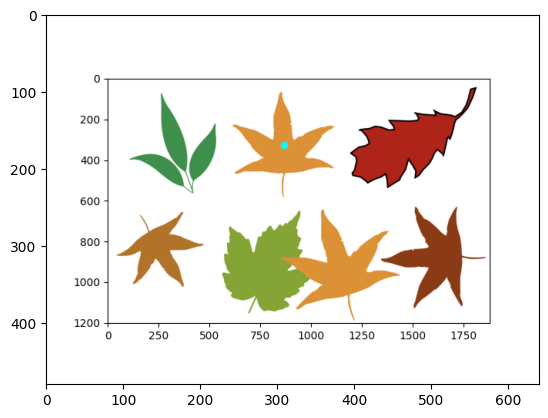

In [55]:
out = cv2.imread('seq_output.png')
plt.imshow(out)

## 2.2 Sequential General Hough Transform with Numba

In [54]:
!python sequence_ght_numba.py

----------Start processing template----------

	 + Time of gray scale process: 1.4727
	 + Time of sobel filter process: 0.81645
	 + Time of magnitude and orientation process: 0.90421
	 + Time of edge minmax process: 0.77661
	 + Time of threshold process: 0.39505
	 + Time of creating R-table process: 1.29224
----------End processing template----------

----------Start accumulating src----------

	 + Time of gray scale process: 0.01258
	 + Time of sobel filter process: 0.04558
	 + Time of magnitude and orientation process: 0.05056
	 + Time of edge minmax process: 0.04129
	 + Time of threshold process: 0.4198
	 + Time of accumulate process: 5.06905
Figure(640x480)
----------End accumulating src----------

Time process template: 5.657259941101074s

Time process source: 5.638855218887329s



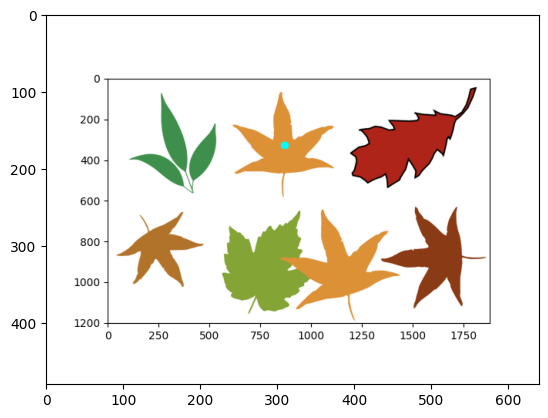

In [56]:
out = cv2.imread('seq_output_numba.png')
plt.imshow(out)

## 2.3 Parallel General Hough Transform on GPU

In [61]:
# chưa parallel accumulating
!python parallel_ght_gpu.py

----------Start processing template----------

	 + Time of gray scale process: 0.38012
	 + Time of sobel filter process: 0.15877
	 + Time of magnitude and orientation process: 0.20784
	 + Time of edge minmax process: 0.22644
	 + Time of threshold process: 0.06917
	 + Time of creating R-table process: 1.42414
----------End processing template----------

----------Start accumulating src----------

	 + Time of gray scale process: 0.02911
	 + Time of sobel filter process: 0.03951
	 + Time of magnitude and orientation process: 0.05966
	 + Time of edge minmax process: 0.02887
	 + Time of threshold process: 0.01662
	 + Time of accumulate process: 4.8373
Figure(640x480)
----------End accumulating src----------

Time process template: 2.4664814472198486s

Time process source: 5.01106333732605s



In [79]:
# parallel accumulating
!python parallel_ght_gpu.py

----------Start processing template----------

	 + Time of gray scale process: 0.47896
	 + Time of sobel filter process: 0.15787
	 + Time of magnitude and orientation process: 0.20535
	 + Time of edge minmax process: 0.16477
	 + Time of threshold process: 0.06934
	 + Time of creating R-table process: 0.19041
----------End processing template----------

Time processing template: 1.2666983604431152

----------Start accumulating src----------

	 + Time of gray scale process: 0.02698
	 + Time of sobel filter process: 0.04111
	 + Time of magnitude and orientation process: 0.0541
	 + Time of edge minmax process: 0.02863
	 + Time of threshold process: 0.0208
	 + Time of accumulate process: 0.14324
Figure(640x480)
----------End accumulating src----------

Time process: 0.3148648738861084s



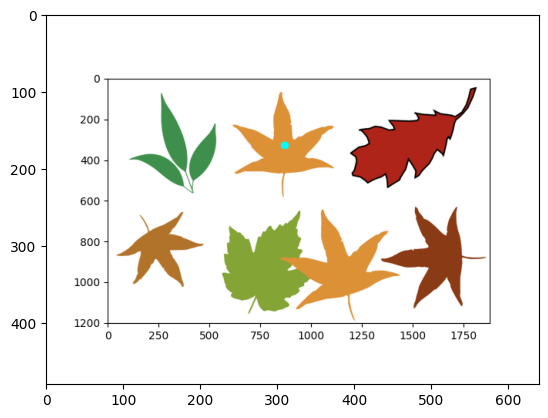

In [62]:
out = cv2.imread('parallel_output_gpu.png')
plt.imshow(out)